# Basic classification: Classify images of clothing
A tensorflow serving style service example using BentoML

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import io

# TensorFlow
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(_train_images, train_labels), (_test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images = _train_images / 255.0
test_images = _test_images / 255.0

In [3]:
class FashionMnist(tf.keras.Model):
    def __init__(self):
        super(FashionMnist, self).__init__()
        self.cnn = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
    
    @staticmethod
    def image_bytes2tensor(inputs):
        inputs = tf.map_fn(lambda i: tf.io.decode_png(i, channels=1), inputs, dtype=tf.uint8)
        inputs = tf.cast(inputs, tf.float32)
        inputs = (255.0 - inputs) / 255.0
        inputs = tf.reshape(inputs, [-1, 28, 28])
        return inputs

    @tf.function
    def predict_image(self, inputs):
        inputs = self.image_bytes2tensor(inputs)
        return self(inputs)
    
    def call(self, inputs):
        return self.cnn(inputs)


## test the image preprocessing

Ankle boot


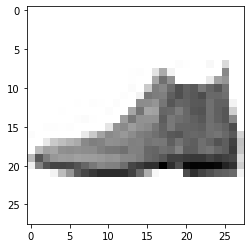

In [4]:
# pick up a test image
d_test_img = _test_images[0]
print(class_names[test_labels[0]])

plt.imshow(255.0 - d_test_img, cmap='gray')
plt.imsave("test.png", 255.0 - d_test_img, cmap='gray')

# read bytes
with open("test.png", "rb") as f:
    img_bytes = f.read()

# verify saved image
assert tf.reduce_mean(FashionMnist.image_bytes2tensor(tf.constant([img_bytes])) - d_test_img) < 0.01

## train the model


In [5]:
model = FashionMnist()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=1)

Train on 60000 samples
60000/60000 [==============================] - 7s 123us/sample - loss: 0.5046 - accuracy: 0.8245


## test the model

In [6]:
predict = model.predict_image(tf.constant([img_bytes]))
klass = tf.argmax(predict, axis=1)[0]
class_names[klass]

'Ankle boot'

And the model predicts a label as expected.

# Define & save bentoml servicer

In [7]:
%%writefile tensorflow_fashion_mnist.py

import bentoml
import tensorflow as tf
import numpy as np
from PIL import Image

from bentoml.artifact import (
    TensorflowSavedModelArtifact,
)
from bentoml.handlers import TensorflowTensorHandler


FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


@bentoml.env(pip_dependencies=['tensorflow', 'numpy'])
@bentoml.artifacts([TensorflowSavedModelArtifact('model')])
class FashionMNISTServicer(bentoml.BentoService):

    @bentoml.api(TensorflowTensorHandler)
    def predict(self, inputs):
        outputs = self.artifacts.model.predict_image(inputs)
        output_classes = tf.math.argmax(outputs, axis=1)
        return FASHION_MNIST_CLASSES[output_classes[0]]


Overwriting tensorflow_fashion_mnist.py


In [9]:
from tensorflow_fashion_mnist import FashionMNISTServicer

bento_svc = FashionMNISTServicer()
bento_svc.pack("model", model)
saved_path = bento_svc.save()


[2019-12-21 13:43:09,301] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.2. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2019-12-21 13:43:10,783] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.2. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml

no previously-included directories found matching 'examples'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'docs'


writing manifest file 'BentoML.egg-info/SOURCES.txt'
running check


creating BentoML-0.5.2+38.g5342a8b
creating BentoML-0.5.2+38.g5342a8b/BentoML.egg-info
creating BentoML-0.5.2+38.g5342a8b/bentoml
creating BentoML-0.5.2+38.g5342a8b/bentoml/artifact
creating BentoML-0.5.2+38.g5342a8b/bentoml/bundler
creating BentoML-0.5.2+38.g5342a8b/bentoml/cli
creating BentoML-0.5.2+38.g5342a8b/bentoml/clipper
creating BentoML-0.5.2+38.g5342a8b/bentoml/configuration
creating BentoML-0.5.2+38.g5342a8b/bentoml/deployment
creating BentoML-0.5.2+38.g5342a8b/bentoml/deployment/aws_lambda
creating BentoML-0.5.2+38.g5342a8b/bentoml/deployment/sagemaker
creating BentoML-0.5.2+38.g5342a8b/bentoml/handlers
creating BentoML-0.5.2+38.g5342a8b/bentoml/migrations
creating BentoML-0.5.2+38.g5342a8b/bentoml/migrations/versions
creating BentoML-0.5.2+38.g5342a8b/bentoml/proto
creating BentoML-0.5.2+38.g5342a8b/bentoml/repository
creating BentoML-0.5.2+38.g5342a8b/bentoml/server
creating BentoML-0.5.2+38.g5342a8b/bentoml/server/static
creating BentoML-0.5.2+38.g5342a8b/bentoml/utils
c

# Serve bentoml REST server locally

In [ ]:
!/opt/anaconda3/envs/bentoml-dev/bin/bentoml serve {saved_path} --port 8890

## query REST API with python

In [26]:
import base64
import json
import requests

with open("test.png", "rb") as f:
    img_bytes = f.read()
img_b64 = base64.b64encode(img_bytes).decode()


headers = {"content-type": "application/json"}
data = json.dumps(
       {"instances": [{"b64": img_b64}]}
)
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

json_response = requests.post(f'http://localhost:8890/predict', data=data, headers=headers)
print(json_response)
print(json_response.text)

Data: {"instances": [{"b64": "iVBORw0KGgoAAAANSUhEUgAAAB ... ufkz8DPG//sD/AX8I8DvdgnOxdB4B1wAAAAASUVORK5CYII="}]}
<Response [200]>
{"predictions": "Ankle boot"}


# CLI access

`pip install $SAVED_PATH` also installs a CLI tool for accessing the BentoML service

In [22]:
import os
import sys

kernel_path = f"{sys.exec_prefix}/bin"
local_path = f"{os.environ['HOME']}/.local/bin"

if kernel_path not in os.environ['PATH']:
    os.environ['PATH'] = f"{kernel_path}:{os.environ['PATH']}"

if local_path not in os.environ['PATH']:
    os.environ['PATH'] = f"{local_path}:{os.environ['PATH']}"

!which pip

/opt/anaconda3/envs/bentoml-dev/bin/pip


In [18]:
!pip install --user {saved_path}

Processing /home/bentoml/bentoml/repository/FashionMNISTServicer/20191221134309_BD2B31
  Created wheel for FashionMNISTServicer: filename=FashionMNISTServicer-20191221134309_BD2B31-cp37-none-any.whl size=1155660 sha256=664fc137a421bf424de195ab46dc0e907c9ceaea6afbfcd000ec7f0bcc527d6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-sqcu33m2/wheels/e1/23/51/46fbaa2a547f141bbbb2ecdeb7e13398141d08fae81095893e
Successfully built FashionMNISTServicer
  Found existing installation: FashionMNISTServicer 20191221134309-BD2B31
    Uninstalling FashionMNISTServicer-20191221134309-BD2B31:
      Successfully uninstalled FashionMNISTServicer-20191221134309-BD2B31
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [23]:
!FashionMNISTServicer info

[2019-12-21 13:51:58,980] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.2. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2019-12-21 13:51:58,990] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.5.2,  but loading from BentoML version 0.5.2+38.g5342a8b
{
  "name": "FashionMNISTServicer",
  "version": "20191221134309_BD2B31",
  "created_at": "2019-12-21T05:43:19.709096Z",
  "env": {
    "conda_env": "name: bentoml-FashionMNISTServicer\nchannels:\n- defaults\ndependencies:\n- p

### Run 'predict' api with json data:

In [24]:
!echo '{\"instances\":[{\"b64\":\"'$(base64 test.png)'\"}]}' > test.json
!cat test.json | xargs -I {} FashionMNISTServicer predict --input={}

[2019-12-21 13:52:09,960] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.2. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2019-12-21 13:52:09,969] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.5.2,  but loading from BentoML version 0.5.2+38.g5342a8b
[2019-12-21 13:52:09,971] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will b

# Additional: serve with tf-serving

In [ ]:
TMP_MODEL_DIR = "/tmp/test-model/"
SERVE_HOST = "http://localhost:8890"
SERVE_PORT = 8890
MODEL_NAME = "fashion_model"
tf.saved_model.save(model, TMP_MODEL_DIR)
!tensorflow_model_server --rest_api_port={SERVE_PORT} --model_name={MODEL_NAME} --model_base_path={TMP_MODEL_DIR}